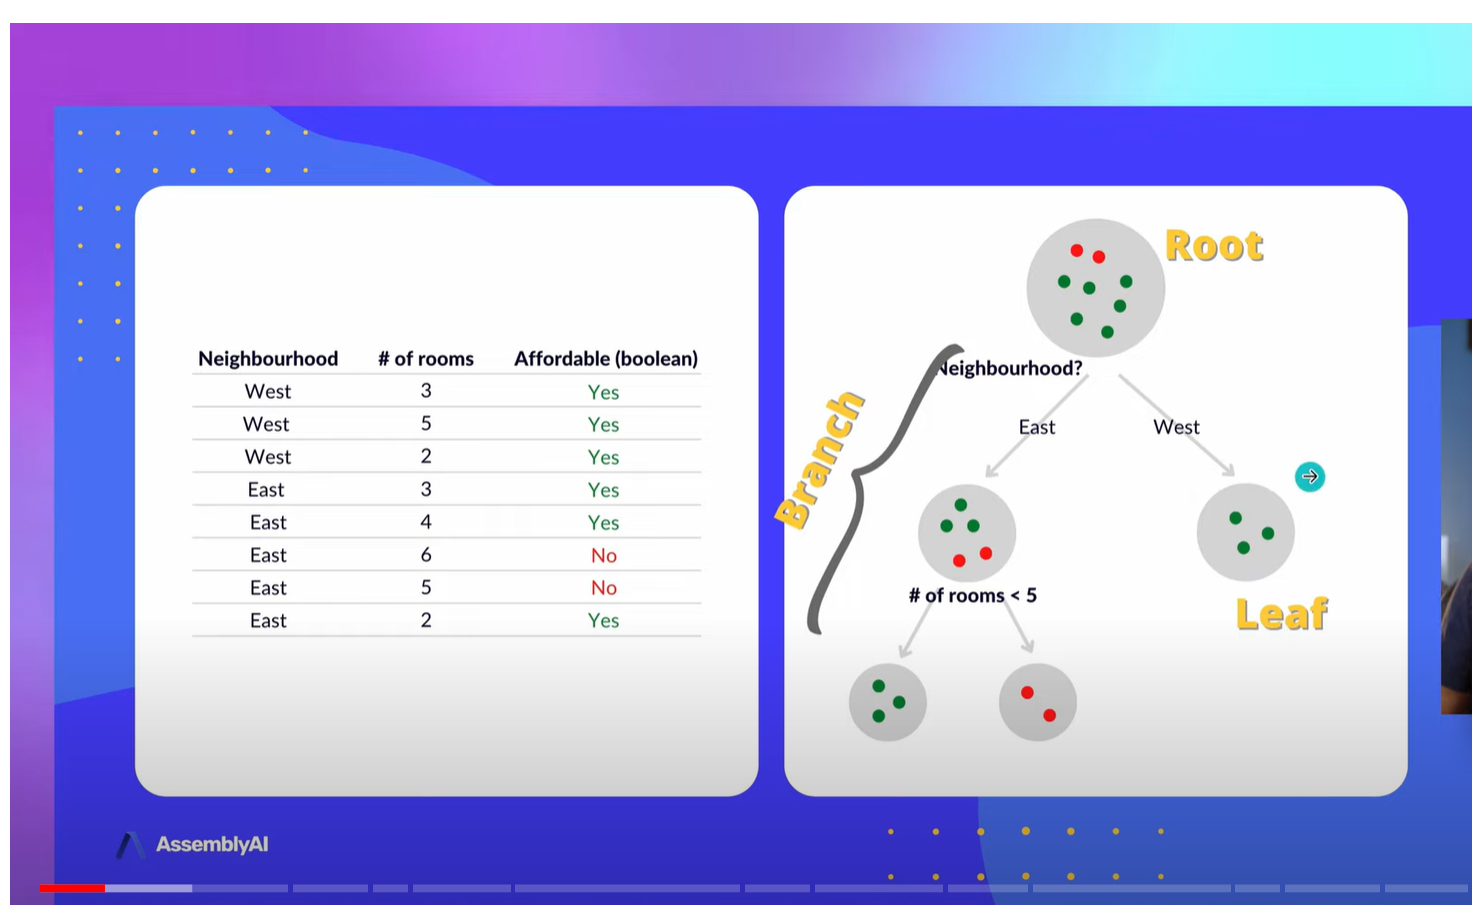

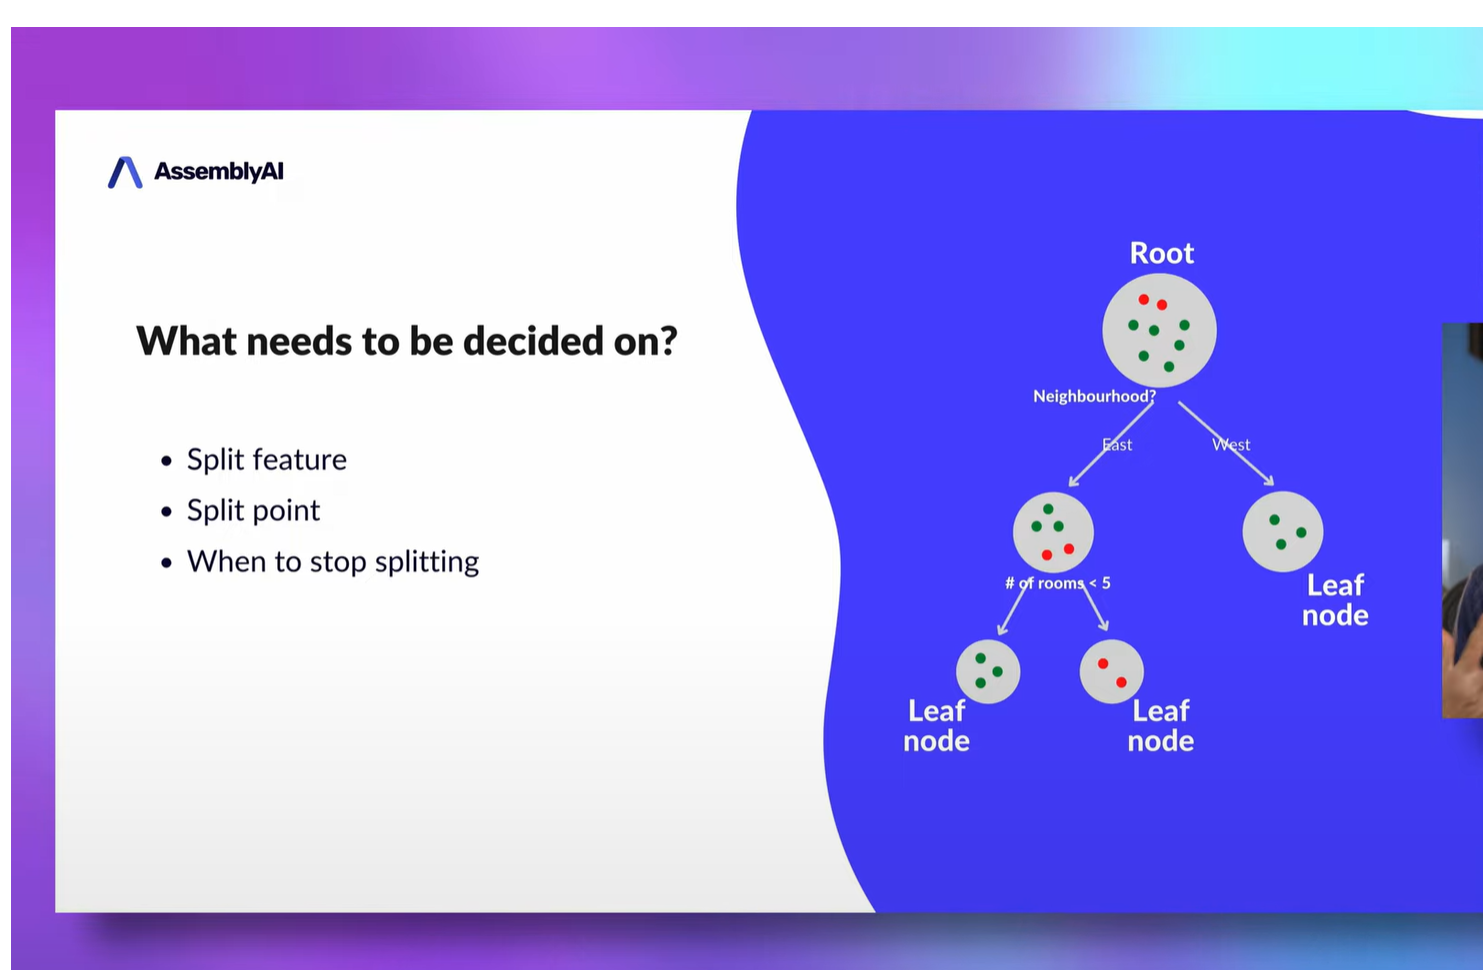

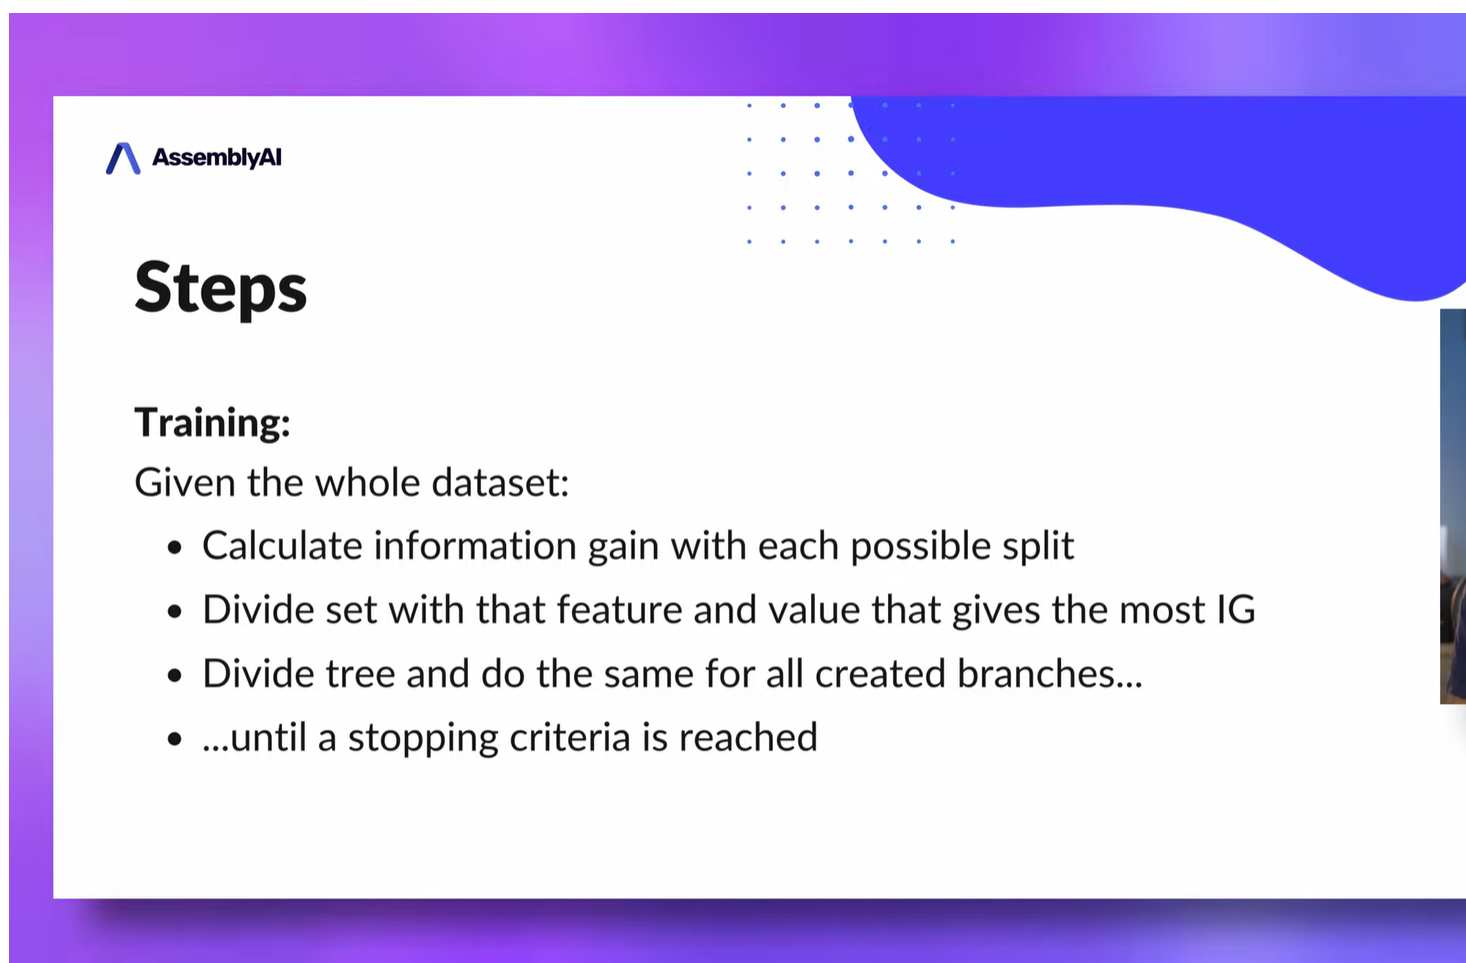

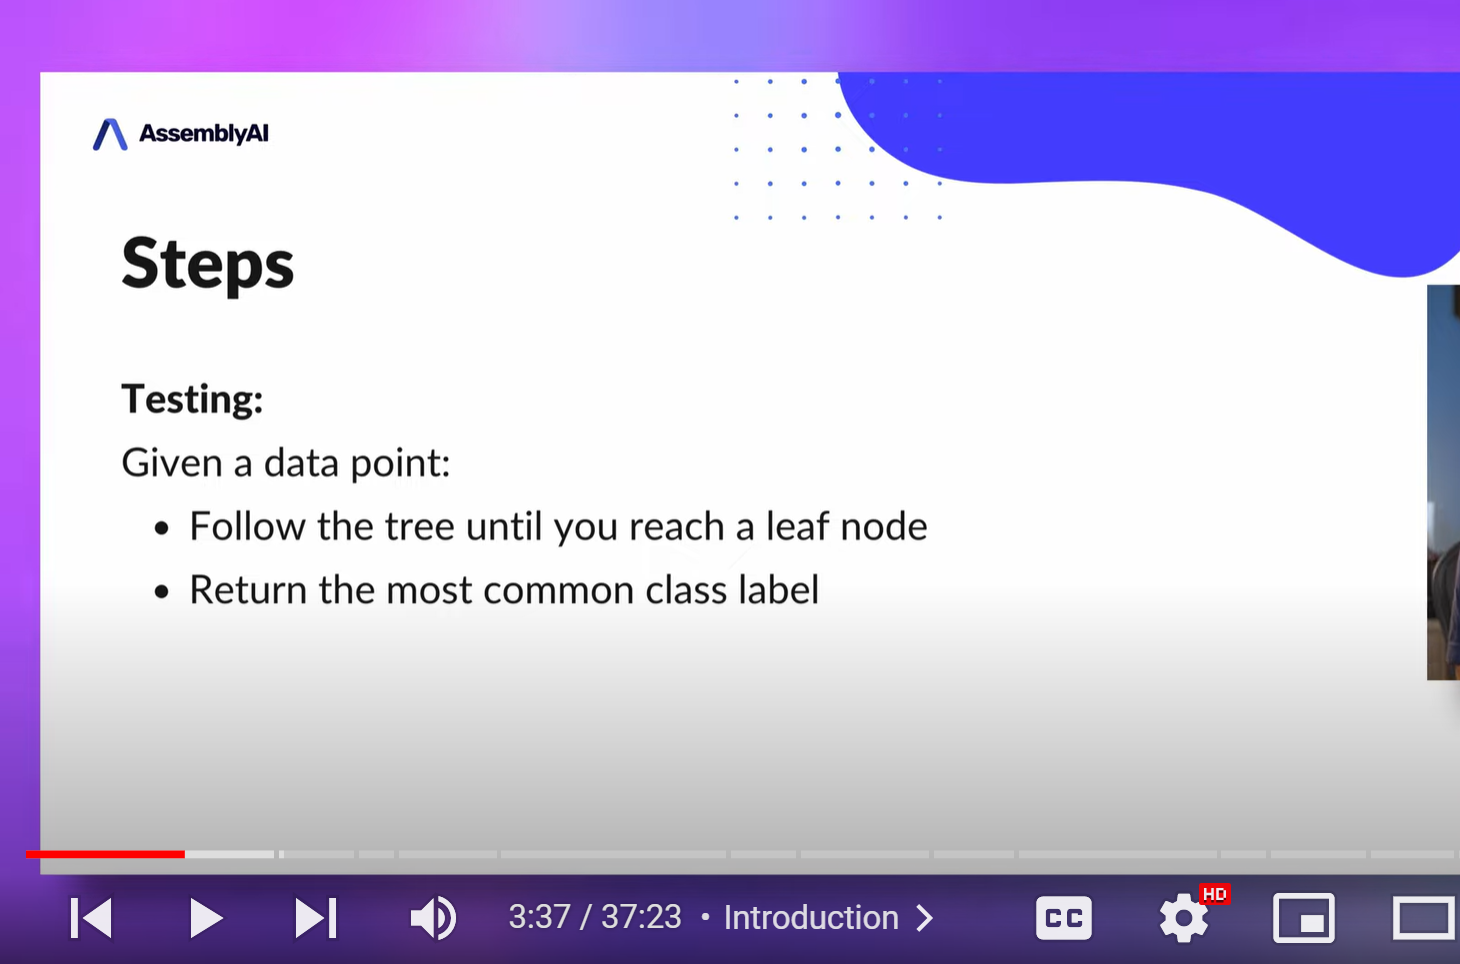

Entropy is lack of order

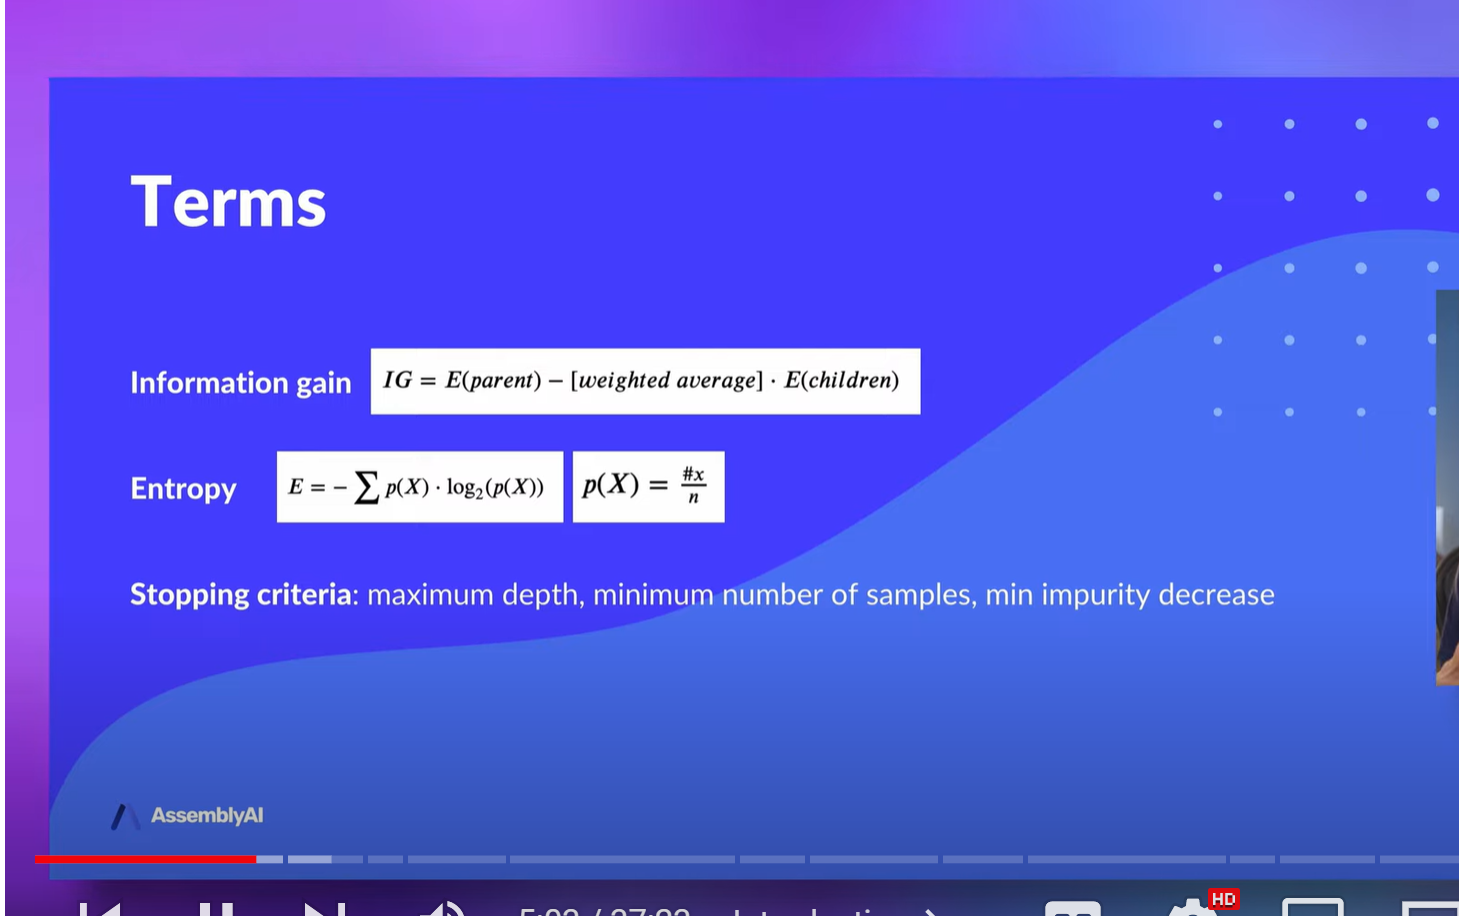

In [5]:
import numpy as np
import pandas as pd
from collections import Counter

In [6]:
#Node class 
class Node:
    def __init__(self,feature=None,threshold=None,left=None,right=None,*,value=None):
        self.feature = feature  #which feature and threshold it was divided with
        self.threshold = threshold
        self.left = left
        self.right = right #which node it points towards right
        self.value = value  #value of the node
      
    def is_leaf_node(self):
        return self.value is not None
    
    


In [7]:
#Decision Tree class 
class DecisionTree:
    def __init__(self,min_samples_split=2,max_depth=100,n_features=None):
        #stopping criteria
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        #not using all features just a subset
        self.n_features = n_features
        self.root = None
        
    
    def fit(self, X, y):
        #need to check no of features do not exceed the no of features
        #we have
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X,y)
        
    
    def _grow_tree(self, X, y, depth=0):
        n_samples,n_feats = X.shape
        n_labels = len(np.unique(y))
        
        #check the stopping criteria
        #1)exceed the max_depth 2)only data of 1 label present(hence leaf node)
        #3)n_samples is smaller than min_sample_split.then we dont wanna split.
        #we just create a node and return.
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        
        #passing total no of features we have, no of features that we wanna select
        #replace to false we dont have duplicates
        feat_idxs = np.random.choice(n_feats,self.n_features,replace=False)
        
        #find the best split
        best_thresh, best_feature = self._best_split(X,y,feat_idxs) #features we need to include while creating the split. this will add randomness to the tree.
        
        #create child nodes
        left_idxs, right_idxs = self._split(X[:,best_feature],best_thresh)
        
        #then call grow_tree to create subtree for the child nodes
        left = self._grow_tree(X[left_idxs,:],y[left_idxs],depth+1)
        right = self._grow_tree(X[right_idxs,:],y[right_idxs],depth+1)
        return Node(feature=best_feature,threshold=best_thresh,left=left,right=right)
        
        
    def _best_split(self,X,y,feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None
        
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx] #only this column 
            #getting all possible values present in this column
            thresholds = np.unique(X_column) 
            
            for thr in thresholds:
                # calculate the info gain for each threshold
                gain = self._information_gain(y,X_column,thr)
                
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr
                    
        return split_threshold,split_idx
                    
    def _information_gain(self,y,X_column,thr):
        #parent entropy
        parent_entropy = self._entropy(y)
        
        #create children
        left_idxs, right_idxs = self._split(X_column, thr)
        
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0 #that is the information gain is 0
        
        #calculate the weighted avg entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        
        child_entropy = (n_l/n)*e_l + (n_r/n)*e_r
        
        #calculate the Information gain
        information_gain = parent_entropy - child_entropy
        
        return information_gain
    
    
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column<=split_thresh).flatten() 
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        
        return left_idxs, right_idxs
        
    
    def _entropy(self,y):
        #getting the no of times each label has occured
        hist = np.bincount(y)
        
        #p(x) - no of occurences divided by total value
        px = hist / len(y)
        
        return -np.sum([p * np.log(p) for p in px if p>0])
        
    def _most_common_label(self,y):
        counter = Counter(y)
        #most common label(and the first one in case 2 labels have same number of elements)
        value = counter.most_common(1)[0][0]
        return value
        
        
    def predict(self, X):
        return np.array([self._traverse_tree(x,self.root) for x in X])
        
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x,node.left)
        return self._traverse_tree(x,node.right)
            
            
            

In [8]:
import sklearn
from sklearn import datasets

bc = datasets.load_breast_cancer()

X,y = bc.data,bc.target

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [9]:
clf = DecisionTree()
clf.fit(X_train,y_train)
preds = clf.predict(X_test)

In [10]:
acc = np.sum(y_test == preds)/len(y_test)
acc

0.916083916083916

In [7]:
x = np.arange(5)
x

array([0, 1, 2, 3, 4])

In [8]:
np.argwhere(x<3)

array([[0],
       [1],
       [2]], dtype=int64)

In [9]:
np.argwhere(x<3).flatten()

array([0, 1, 2], dtype=int64)

In [4]:
y = np.array([1,2,3,1,2])

In [5]:
np.bincount(y) #0 has occur 0 times, 1 has occured 2 times,2 has ..

array([0, 2, 2, 1], dtype=int64)